In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from textwrap import wrap


In [32]:
amazon_data = pd.read_csv('../data/cleaned/cleaned_data.csv')

In [33]:
amazon_data.head()

dateAdded                dateUpdated  \
0  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
1  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
2  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
3  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
4  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   

                                                name   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   

  primaryCategories               reviews.date  reviews.rating  \
0       Electronics  2017-09-03 00:00:00+00:00               3   
1       Electronics  2017-06-06 00:00:00+00:00               5   
2       Electronics  2018-04-20 00:00:00+00:00               4   
3       Electronics  2017-11-02 17:33:31+00:00               5   
4       Electronics  2018-04-24 00:00:00+00:00               5   

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                  reviews.title reviews.username  
0                                     Too small           llyyue  
1  Great light reader. Easy to use at the beach           Charmi  
2                           Great for the price     johnnyjojojo  
3                                   A Great Buy          Kdperry  
4      Solid entry-level Kindle. Great for kids      Johnnyblack

Total ratings 4987
Total users 3807
User giving bulk rating (more than 10)8
Bulk ratings : 116
Populations of bulk ratings : 2.3260477240826147
Populations of bulk users : 0.21013921723141582


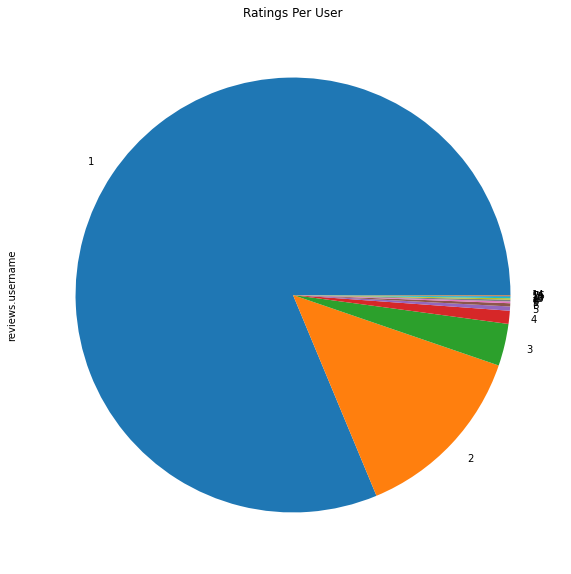

In [34]:
# Check it ratings are genuine 
rating_perperson = amazon_data['reviews.username'].value_counts()
print("Total ratings "+str(sum(rating_perperson)))
print("Total users "+str(len(rating_perperson)))
print("User giving bulk rating (more than 10)"+ str(sum(rating_perperson > 10)))
bulk = rating_perperson[rating_perperson >10]
bulk_rating = sum(bulk)
print ("Bulk ratings : " + str(bulk_rating))
print ("Populations of bulk ratings : " + str(bulk_rating*100/sum(rating_perperson)))
print ("Populations of bulk users : " + str(sum(rating_perperson >10)*100/len(rating_perperson)))
rating_perperson.value_counts().plot(kind='pie',figsize=(10,10), title='Ratings Per User')

Only 0.2 % users are bulk users 

count    116.000000
mean       4.586207
std        0.723145
min        2.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: reviews.rating, dtype: float64
count    4871.000000
mean        4.595976
std         0.732760
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: reviews.rating, dtype: float64


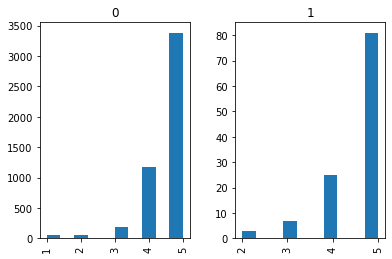

In [35]:
amazon_data['bulk']= amazon_data['reviews.username'].apply(lambda x : 1 if x in bulk.index else 0)
#gives us the category whether a rating is bulk or not 
print(amazon_data['reviews.rating'].hist(by=amazon_data.bulk))
print(amazon_data[amazon_data.bulk==1]['reviews.rating'].describe())
print(amazon_data[amazon_data.bulk==0]['reviews.rating'].describe())

The bulk rating distribution is same as normal rating so it is not a spam

*** Rating distribution ***
5    3465
4    1208
3     197
1      63
2      54
Name: reviews.rating, dtype: int64


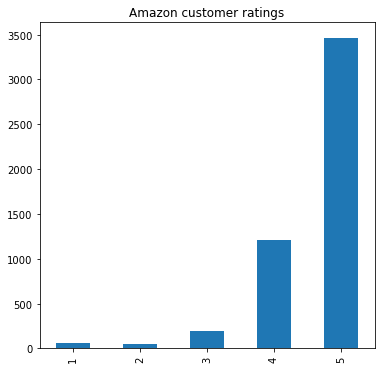

In [36]:
# Distribution on ratings 
star = amazon_data['reviews.rating'].value_counts()
print("*** Rating distribution ***")
print(star)
star.sort_index(inplace=True)
star.plot(kind='bar',title='Amazon customer ratings',figsize=(6,6),style='Solarize_Light2')

In [37]:
data = amazon_data.groupby('name').mean().reset_index()


In [38]:
data = data.sort_values(['reviews.rating']).reset_index()

In [39]:
data.head()

index                                               name  reviews.rating  \
0      1  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...        4.400000   
1     11  Amazon Kindle E-Reader 6" Wifi (8th Generation...        4.406250   
2     19  Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...        4.460916   
3     12  Amazon Tap - Alexa-Enabled Portable Bluetooth ...        4.506667   
4     15  Fire HD 8 Tablet with Alexa, 8" HD Display, 32...        4.509434   

       bulk  
0  0.000000  
1  0.041667  
2  0.026954  
3  0.013333  
4  0.000000

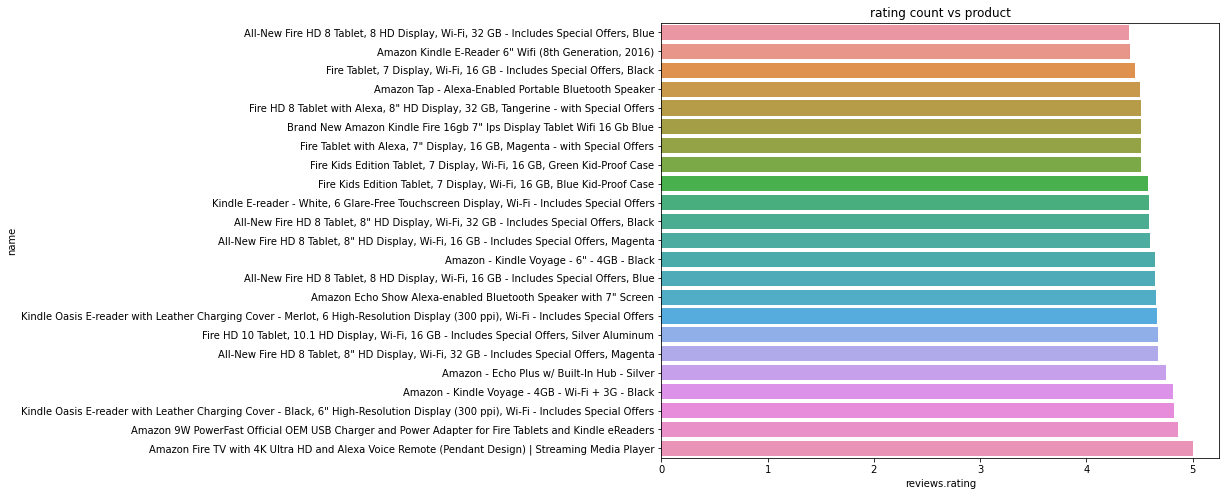

In [40]:
plt.figure(figsize=(10,8))
sns.barplot(x=data['reviews.rating'],y=data['name'])
plt.title('rating count vs product')
plt.show()

In [41]:
amazon_data['reviewsText']=amazon_data['reviews.text'] + amazon_data['reviews.title']
amazon_data.drop(['reviews.text','reviews.title'],axis=1)

dateAdded                dateUpdated  \
0     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
1     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
2     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
3     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
4     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
...                         ...                        ...   
4982  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   
4983  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   
4984  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   
4985  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   
4986  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   

                                                   name   brand  \
0     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
1     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
2     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
3     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
4     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
...                                                 ...     ...   
4982  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   
4983  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   
4984  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   
4985  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   
4986  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   

     primaryCategories               reviews.date  reviews.rating  \
0          Electronics  2017-09-03 00:00:00+00:00               3   
1          Electronics  2017-06-06 00:00:00+00:00               5   
2          Electronics  2018-04-20 00:00:00+00:00               4   
3          Electronics  2017-11-02 17:33:31+00:00               5   
4          Electronics  2018-04-24 00:00:00+00:00               5   
...                ...                        ...             ...   
4982       Electronics  2016-10-21 00:00:00+00:00               5   
4983       Electronics  2016-08-10 00:00:00+00:00               5   
4984       Electronics  2016-06-05 00:00:00+00:00               4   
4985       Electronics  2016-09-02 00:00:00+00:00               5   
4986       Electronics  2016-05-19 00:00:00+00:00               5   

     reviews.username  bulk                                        reviewsText  
0              llyyue     0  I thought it would be as big as small paper bu...  
1              Charmi     0  This kindle is light and easy to use especiall...  
2        johnnyjojojo     0  Didnt know how much i'd use a kindle so went f...  
3             Kdperry     0  I am 100 happy with my purchase. I caught it o...  
4         Johnnyblack     0  Solid entry level Kindle. Great for kids. Gift...  
...               ...   ...                                                ...  
4982            litle     0  This is a great tablet for the price. Amazon i...  
4983           gracie     0  This tablet is the perfect size and so easy to...  
4984             Hawk     0  Purchased this for my son. Has room to upgrade...  
4985          Mrbilly     0  I had some thoughts about getting this for a 5...  
4986           tabman     0  this is a steal, have 8 gb model as well.This ...  

[4987 rows x 10 columns]

In [42]:
# !pip install WordCloud

In [43]:
# Removing unwanted characters from the names
amazon_data['name'].unique()
amazon_data['name'] = amazon_data['name'].apply(lambda x:x.split(',,,')[0])


In [44]:
amazon_data['reviewsText']

0       I thought it would be as big as small paper bu...
1       This kindle is light and easy to use especiall...
2       Didnt know how much i'd use a kindle so went f...
3       I am 100 happy with my purchase. I caught it o...
4       Solid entry level Kindle. Great for kids. Gift...
                              ...                        
4982    This is a great tablet for the price. Amazon i...
4983    This tablet is the perfect size and so easy to...
4984    Purchased this for my son. Has room to upgrade...
4985    I had some thoughts about getting this for a 5...
4986    this is a steal, have 8 gb model as well.This ...
Name: reviewsText, Length: 4987, dtype: object

## Preprocessing - removing punctuations, digits and unnecessary jargons

In [45]:
# Convert words to lower case in reviews text
amazon_data['reviewsText'] = amazon_data['reviewsText'].apply(lambda x: x.lower())

In [46]:
# Eliminate digits and punctuations
amazon_data['reviewsText'] = amazon_data['reviewsText'].apply(lambda x: re.sub('\w*\d\w*','',x))
amazon_data['reviewsText'] = amazon_data['reviewsText'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation),'',x))

In [47]:
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

words = amazon_data['reviewsText'].str.split()
stopwords_present = stopwords.words('english')
ps = PorterStemmer()
words = words.apply(lambda elem:[word for word in elem if not word in stopwords_present])
words = words.apply(lambda elem:[ps.stem(word) for word in elem])
amazon_data['cleanedReviewText'] = words.apply(lambda elem: ' '.join(elem))
amazon_data['cleanedReviewText'].head()

0    thought would big small paper turn like palm t...
1    kindl light easi use especi beachgreat light r...
2    didnt know much id use kindl went lower end im...
3    happi purchas caught sale realli good price no...
4    solid entri level kindl great kid gift kid fri...
Name: cleanedReviewText, dtype: object

In [48]:
# sentiment= {1:0,
#             2: 0,
#             3: 1,
#             4: 2,
#             5: 2}

# amazon_data["sentiment"] = amazon_data["reviews.rating"].map(sentiment)
# amazon_data["sentiment"] = pd.to_numeric(amazon_data["sentiment"], errors='coerce')                                    
# amazon_data = amazon_data.dropna(subset=["sentiment"])
# amazon_data["sentiment"]  = amazon_data["sentiment"] .astype(int)
# amazon_data['sentiment'].head()
amazon_data['reviews.rating'].astype(int)

0       3
1       5
2       4
3       5
4       5
       ..
4982    5
4983    5
4984    4
4985    5
4986    5
Name: reviews.rating, Length: 4987, dtype: int32

In [49]:
# Generate document term matrix  to find most occuring terms in reviews
text = amazon_data.copy()
cv = TfidfVectorizer(analyzer='word')
data = cv.fit_transform(text['cleanedReviewText'])
text_dm = pd.DataFrame(data.toarray(),columns=cv.get_feature_names())
text.set_index('name',inplace=True)
text_dm.index = text.index
text_dm.head()

abc  abil  abilitiesfun  \
name                                                                          
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   

                                                    abilitiesnic  \
name                                                               
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   

                                                    abilityexcel  abk  abl  \
name                                                                         
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   

                                                    aboutfun  aboutgreat  \
name                                                                       
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   

                                                    aboveoveral  ...  äúalexa  \
name                                                             ...            
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   

                                                    äúbest  äúdrop  \
name                                                                 
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   

                                                    äúdualbatteri  äúshow  \
name                                                                        
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   

                                                    äúskills  äústar  äúthing  \
name                                                                            
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0     0.0      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0     0.0      0.0   
Amazon Kindle E-Re

In [50]:
text_dm.shape

(4987, 7144)

In [51]:
text_dm = text_dm.groupby(text_dm.index).sum()
text_dm.shape

(23, 7144)

In [52]:
text_dm.head()

abc      abil  \
name                                                                
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  0.0  0.000000   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  0.0  0.019080   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.0  1.679192   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.0  0.000000   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.0  0.019080   

                                                    abilitiesfun  \
name                                                               
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...           0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...           0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0   

                                                    abilitiesnic  \
name                                                               
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...      0.000000   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...      0.000000   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...      0.615179   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...      0.000000   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...      0.000000   

                                                    abilityexcel  abk  \
name                                                                    
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...           0.0  0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...           0.0  0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0  0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0  0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0  0.0   

                                                         abl  aboutfun  \
name                                                                     
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  0.133918       0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  0.191073       0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  3.221180       0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.000000       0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.248692       0.0   

                                                    aboutgreat  aboveoveral  \
name                                                                          
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...         0.0          0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...         0.0          0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...         0.0          0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...         0.0          0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...         0.0          0.0   

                                                    ...  äúalexa  äúbest  \
name                                                ...                    
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  ...      0.0     0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  ...      0.0     0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  ...      0.0     0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  ...      0.0     0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  ...      0.0     0.0   

                                                    äúdrop  äúdualbatteri  \
name                                                                        
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...     0.0            0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...     0.0            0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...     0.0            0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...     0.0            0.0   
All-New Fire HD 8 Tablet, 8" HD Di

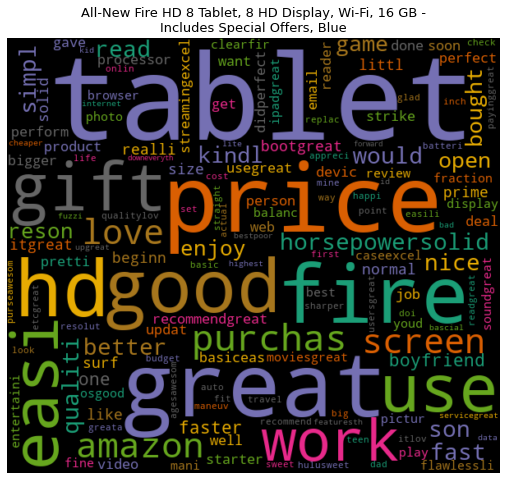

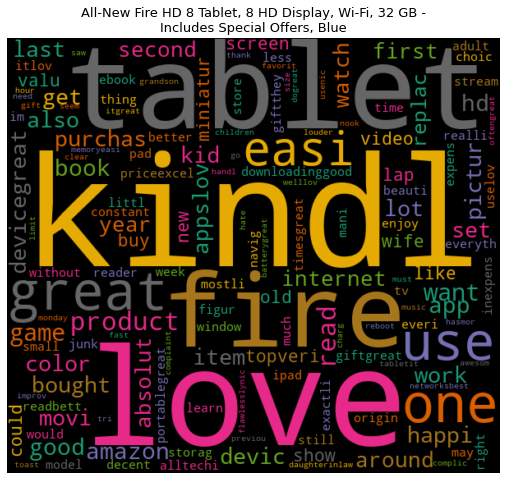

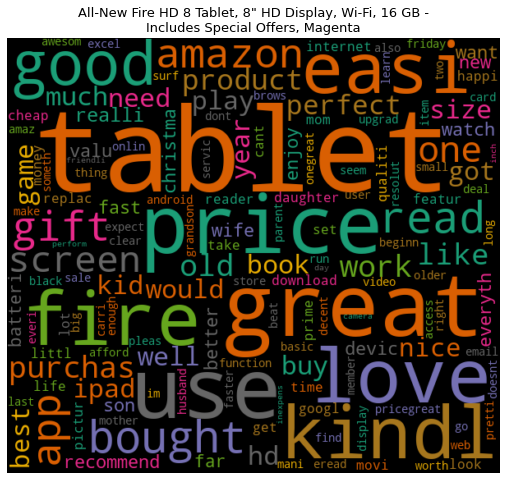

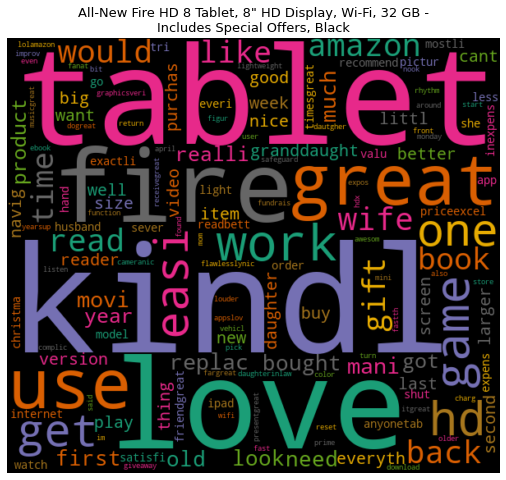

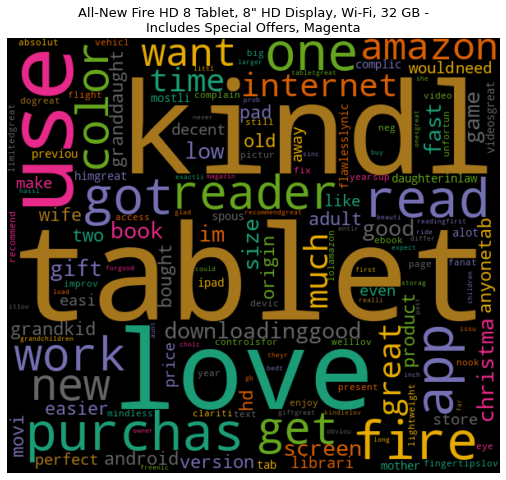

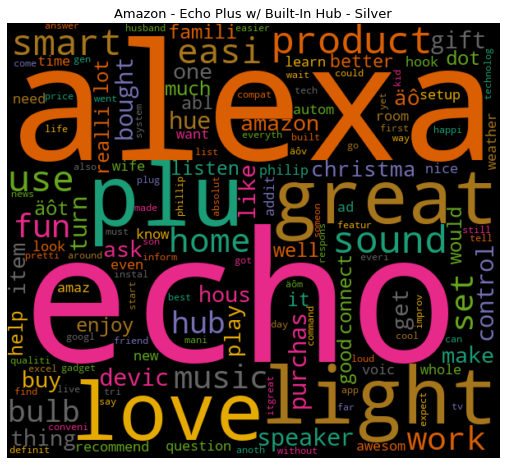

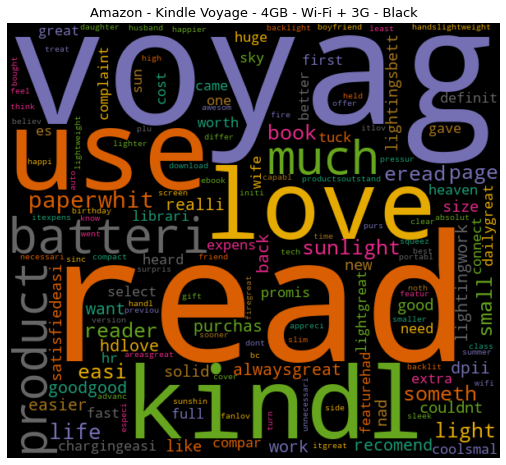

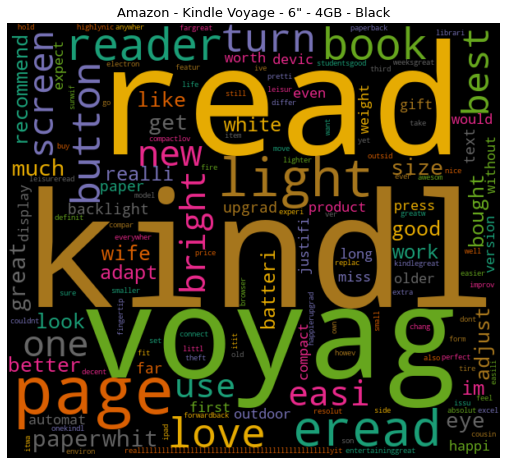

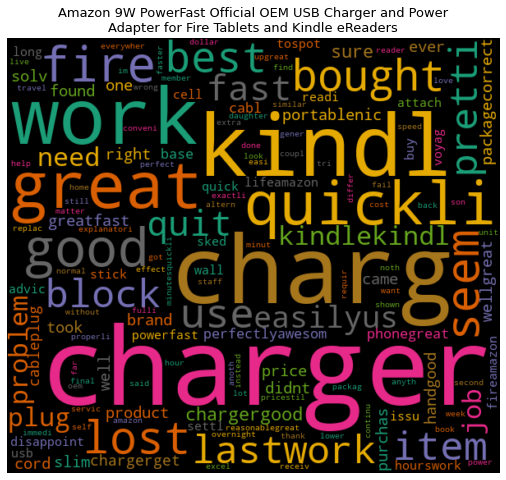

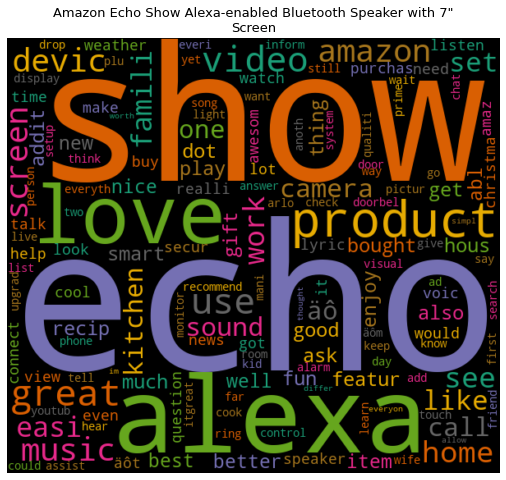

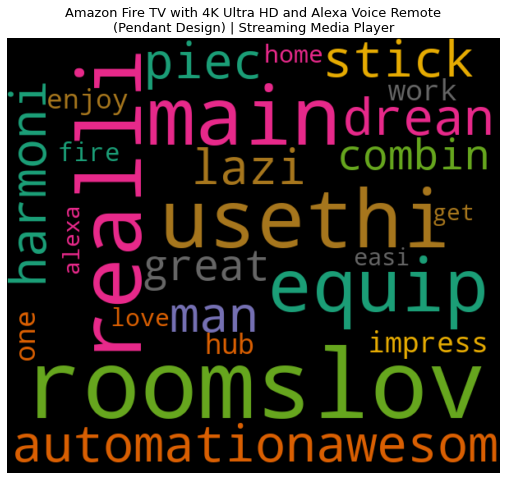

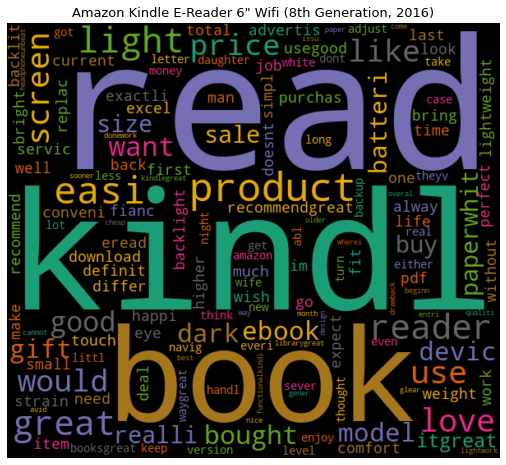

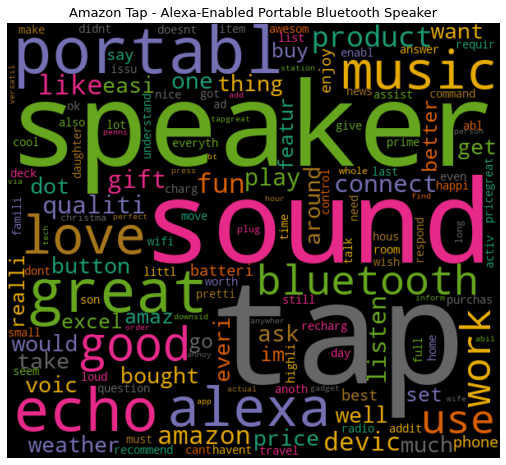

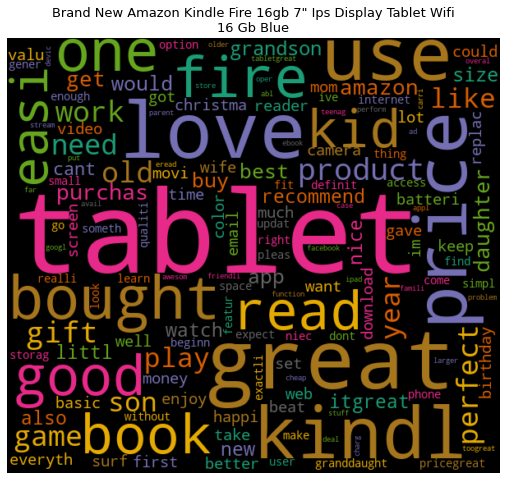

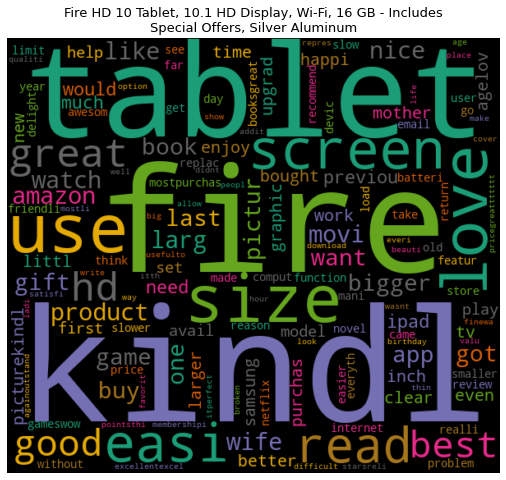

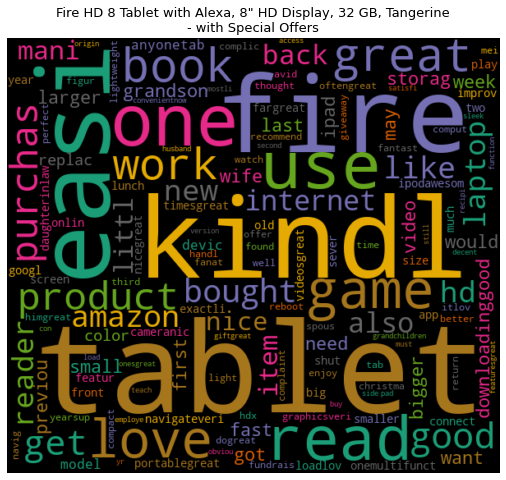

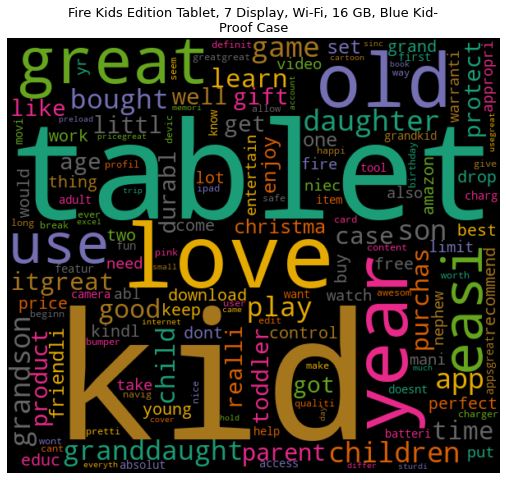

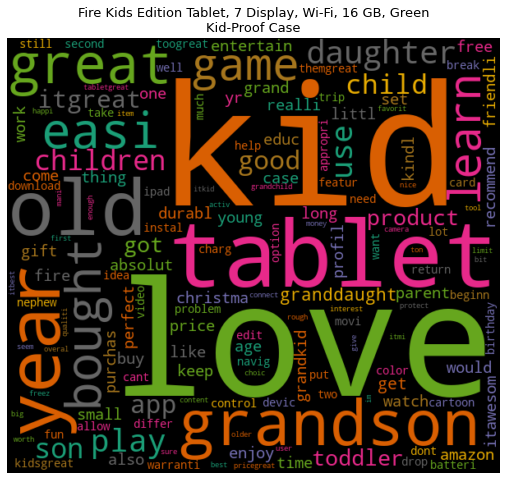

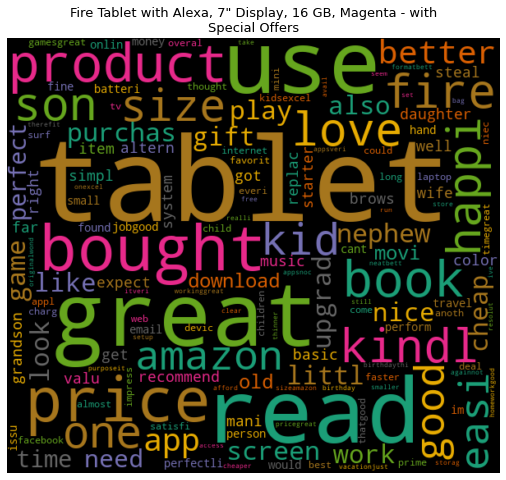

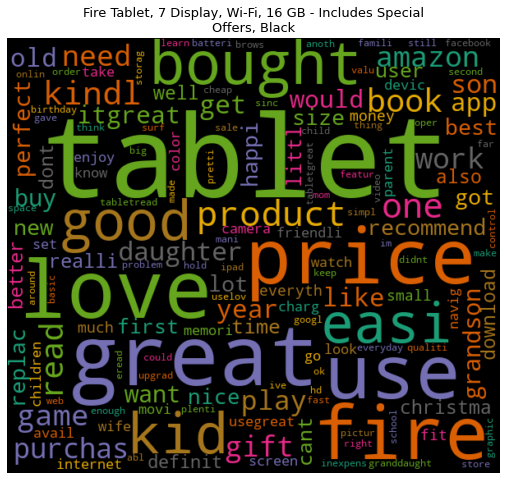

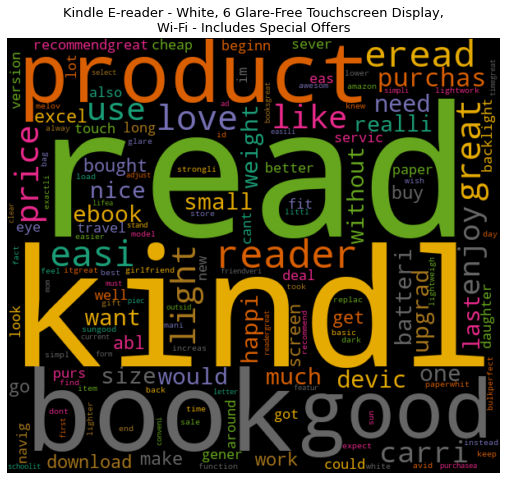

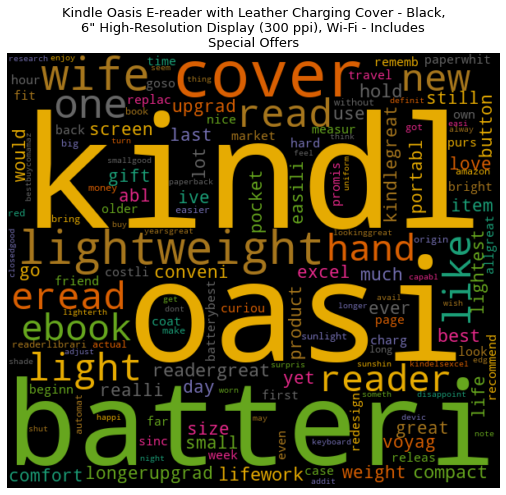

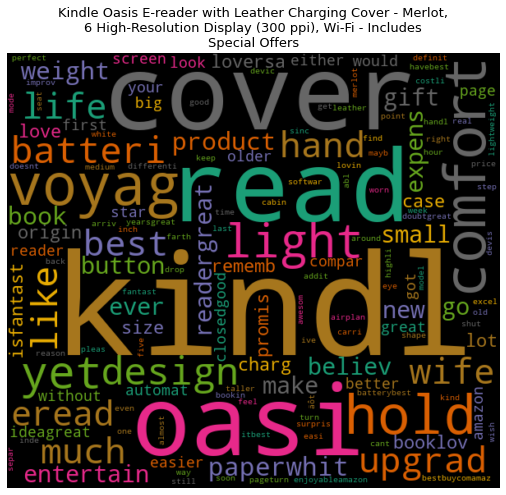

In [53]:
def wordcloud(data,title):
  wc = WordCloud(width=600, height=530, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
text_dm = text_dm.transpose()
for index,product in enumerate(text_dm.columns):
   wordcloud(text_dm[product].sort_values(ascending=False),product)
    

### Splitting data into testing and training 

In [54]:
from sklearn.model_selection import train_test_split
y = amazon_data['reviews.rating'].values
X = amazon_data['cleanedReviewText']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [55]:
cv.fit(X_train)
X_test_trans = cv.transform(X_test)
X_train_trans = cv.transform(X_train)

In [56]:
amazon_data['reviews.rating'].describe()

count    4987.000000
mean        4.595749
std         0.732467
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: reviews.rating, dtype: float64

# Modeling

In [105]:
# !pip install xgboost

In [143]:
## All imports for modeling
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from  sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics


In [111]:
def modeling(Model, Xtrain = X_train_trans, Xtest = X_test_trans):
    """
    This function apply TFIDF with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

In [127]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T


In [141]:
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=[0,1,2,3,4,5]
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [149]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'TF-IDF'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

In [150]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

### 1.1 Logistic Regression with TF-IDF

In [112]:

# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred


f1 score: 0.6803672587385019


#### Classification report

In [113]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           1       0.35      0.57      0.43        14
           2       0.07      0.33      0.12         6
           3       0.20      0.47      0.28        36
           4       0.46      0.43      0.44       246
           5       0.83      0.76      0.79       696

    accuracy                           0.66       998
   macro avg       0.38      0.51      0.41       998
weighted avg       0.71      0.66      0.68       998



### 1.2 RandomForest with TF-IDF

In [114]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred


f1 score: 0.7396134653075898


#### Classfication report

In [115]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           1       1.00      0.50      0.67        14
           2       1.00      0.33      0.50         6
           3       1.00      0.19      0.33        36
           4       0.86      0.31      0.46       246
           5       0.77      0.99      0.86       696

    accuracy                           0.78       998
   macro avg       0.92      0.47      0.56       998
weighted avg       0.80      0.78      0.74       998



### 1.3 Navie Bayes with TF-IDF

In [116]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.5730658483436768


#### Classfication report

In [117]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00       246
           5       0.70      1.00      0.82       696

    accuracy                           0.70       998
   macro avg       0.14      0.20      0.16       998
weighted avg       0.49      0.70      0.57       998



C:\Users\hp pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1.4 XGBoost with TF-IDF

In [118]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

C:\Users\hp pc\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.7265908053343921


#### Classification report

In [119]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           1       0.80      0.57      0.67        14
           2       0.50      0.33      0.40         6
           3       1.00      0.19      0.33        36
           4       0.62      0.33      0.43       246
           5       0.78      0.95      0.86       696

    accuracy                           0.76       998
   macro avg       0.74      0.48      0.54       998
weighted avg       0.75      0.76      0.73       998



In [151]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

C:\Users\hp pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [152]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                  
TF-IDF     LogReg        0.662325 0       0.347826  0.571429  0.432432   
                                  1       0.071429  0.333333  0.117647   
                                  2       0.202381  0.472222  0.283333   
                                  3       0.462555  0.426829  0.443975   
                                  4       0.831761  0.760057  0.794294   
                                  5       0.706691  0.662325  0.680367   
           Random Forest 0.780561 0       1.000000  0.500000  0.666667   
                                  1       1.000000  0.333333  0.500000   
                                  2       1.000000  0.194444  0.325581   
                                  3       0.855556  0.313008  0.458333   
                                  4       0.769058  0.985632  0.863980   
                                  5       0.803338  0.780561  0.739613   
           Naive Bayes   0.697395 0       0.000000  0.000000  0.000000   
                                  1       0.000000  0.000000  0.000000   
                                  2       0.000000  0.000000  0.000000   
                                  3       0.000000  0.000000  0.000000   
                                  4       0.697395  1.000000  0.821724   
                                  5       0.486359  0.697395  0.573066   
           XGBoost       0.760521 0       0.800000  0.571429  0.666667   
                                  1       0.500000  0.333333  0.400000   
                                  2       1.000000  0.194444  0.325581   
                                  3       0.625000  0.325203  0.427807   
                                  4       0.779741  0.951149  0.856958   
                                  5       0.748146  0.760521  0.726591   

                                         support  
vectorizer model         accuracy class           
TF-IDF     LogReg        0.662325 0         14.0  
                                  1          6.0  
                                  2         36.0  
                                  3        246.0  
                                  4        696.0  
                                  5        998.0  
           Random Forest 0.780561 0         14.0  
                                  1          6.0  
                                  2         36.0  
                                  3        246.0  
                                  4        696.0  
                                  5        998.0  
           Naive Bayes   0.697395 0         14.0  
                                  1          6.0  
                                  2         36.0  
                                  3        246.0  
                                  4        696.0  
                                  5        998.0  
           XGBoost       0.760521 0         14.0  
                                  1          6.0  
                                  2         36.0  
                                  3        246.0  
                                  4        696.0  
                                  5        998.0

In [153]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

C:\Users\hp pc\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ValueError: max() arg is an empty sequence